In [2]:
# pytorch가 전세계적으로 가장 많이 사용되는 라이브러리. 한국에서는 tensorflow가 많이 사용된다.
import torch
import torch.nn as nn
import torch.nn.functional as F # 직접 작성한 활성화, 손실 함수를 F.000으로 대체하는 것
import torchvision # 효율적인 이미지 및 비디오 변환을위한 유틸리티, dataset 불러오기
import torchvision.transforms as transforms # 일반적인 이미지 변환이며, .compose를 붙여서 사용할 수 있다.
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [3]:
BATCH_SIZE = 32 # training data를 32개로 잘라서 사용

## transformations : 여러 transform 들을 Compose로 구성할 수 있습니다.
transform = transforms.Compose([transforms.ToTensor()]) # .ToTensor() : 데이터 타입을 Tensor 형태로 변경

## download and load training dataset
# 경로, 어떤 데이터로 가져올껀지, 경로에 없으면 다운로드 해라, transform
mnist_trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
# torch.utils.data.DataLoader : PyTorch 데이터 불러오기 기능의 핵심, 데이터를 파이썬 iterable로써 접근할 수 있게 해주는 클래스
# 가져올 데이터, batch 크기, batch 가져올때 랜덤으로 가져올지, 데이터 로딩에 사용하는 subprocess개수
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

## download and load testing dataset
mnist_testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

print(mnist_trainset)
print(mnist_testset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset KMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train - image batch dimensions: torch.Size([32, 1, 28, 28])
Train - image label dimensions: torch.Size([32])
Test - image batch dimensions: torch.Size([32, 1, 28, 28])
Test - image label dimensions: torch.Size([32])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


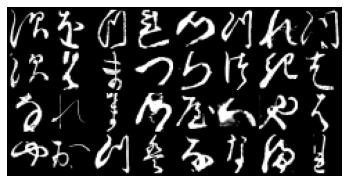

In [4]:
## get some random training images
mnist_dataiter = iter(mnist_trainloader)
images, labels = mnist_dataiter.next()

# print(images.shape)
for images, labels in mnist_trainloader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

# print(labels.shape)
for images, labels in mnist_testloader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

## show images
images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.convlayer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.fclayer1 = nn.Linear(26 * 26 * 32, 128)
        self.fclayer2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.convlayer(x)        # input: 32x1x28x28    -> output: 32x32x26x26
        x = F.relu(x)
        x = x.flatten(start_dim = 1) # input: 32x32x26x26   -> output: 32x(32*26*26)
        x = self.fclayer1(x)         # input: 32x(32*26*26) -> output: 32x128
        x = F.relu(x)
        logits = self.fclayer2(x)    # input: 32x128        -> output: 32x10 (32 images, 10 classes)
        out = F.softmax(logits, dim=1)
        return out

model = SimpleModel()
for images, labels in mnist_trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

summary(model, input_size=(1,28,28))

In [ ]:
def compute_stat(outputs, labels, stats):
    _, preds = torch.max(outputs, 1)
    stats['n_corr'] += torch.sum(preds == labels).item()
    stats['n'] += torch.numel(labels)

    return stats

def train_model(model, criterion, optimizer, trainloader, device, num_epochs=25):
  epoch_stat = {'n_corr': 0, 'n': 0}

  for epoch in range(num_epochs):
      train_running_loss = 0.0
      train_acc = 0.0

      model.train()  # Set model to training mode

      for i, (images, labels) in enumerate(trainloader): # training step / batch 하나씩 처리하는 for문
          
          images = images.to(device) # cpu에서 gpu로 data 넘김
          labels = labels.to(device)
          optimizer.zero_grad() # grdient 초기 상태로

          outputs = model(images) # feed forward
          loss = criterion(outputs, labels) # 오차
          loss.backward() # backprop : loss에 따라 gradient가 계산됨
          optimizer.step() # weight 값들이 조절됨

          train_running_loss += loss.detach().item() # 에러값이 어떻게 계산되었는지 확인하기위해 더하주고 있음
          epoch_stat = compute_stat(outputs, labels, epoch_stat) # 얼마나 정답인지 등 stat 표기.
      
      model.eval() # evaluation(평가) mode로 전환
      print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, epoch_stat['n_corr'] / epoch_stat['n'] * 100)) 
      
  return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleModel()
model = model.to(device) # cpu에서 gpu로 data 넘김

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # optimization
num_epochs = 5

model = train_model(model, criterion, optimizer, mnist_trainloader, device, num_epochs)

In [ ]:
model.eval() # Set model to evaluate mode

test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(mnist_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))